In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import os

2025-01-20 17:11:21.140654: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 17:11:21.152431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 17:11:21.165911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 17:11:21.170527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 17:11:21.180701: I tensorflow/core/platform/cpu_feature_guar

In [3]:
dataset_dir = './garbage_classification/'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 12415 images belonging to 12 classes.


In [6]:
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_generator = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the validation split
)

Found 3100 images belonging to 12 classes.


In [9]:
class_names = train_generator.classes

class_names

array([ 0,  0,  0, ..., 11, 11, 11], dtype=int32)

In [5]:
dim = 150  # Input image dimensions
classes = list(train_generator.class_indices.keys())  # Class labels
initial_learning_rate = 1e-4
epochs_1 = 30
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size


In [6]:
classes

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

In [7]:
conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(dim, dim, 3))
conv_base.trainable = False 

I0000 00:00:1737379965.351537   10802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737379965.611553   10802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737379965.611768   10802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737379965.612921   10802 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [8]:
from tensorflow.keras.layers import GlobalAveragePooling2D


In [9]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(len(classes), activation='softmax')  # Output layer for classification
])


In [10]:
from tensorflow.keras import  optimizers


In [11]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        12,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,049,804 (26.89 MB)

 Trainable params: 12,300 (48.05 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [13]:
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10
    return lr * drop_rate if (epoch % epochs_drop == 0 and epoch > 0) else lr

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs_1,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)]  # Optional learning rate scheduler
)



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/30


/home/stonie/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732862353.730571    2880 service.cc:146] XLA service 0x793a20015b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732862353.730595    2880 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-29 09:39:14.014781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-29 09:39:15.655833: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907

  1/387 ━━━━━━━━━━━━━━━━━━━━ 2:28:26 23s/step - accuracy: 0.0312 - loss: 5.3132

I0000 00:00:1732862367.856899    2880 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.2190 - loss: 3.5201

2024-11-29 09:41:01.681633: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3304', 140 bytes spill stores, 140 bytes spill loads



387/387 ━━━━━━━━━━━━━━━━━━━━ 123s 258ms/step - accuracy: 0.2193 - loss: 3.5187 - val_accuracy: 0.5524 - val_loss: 1.5284 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/30
  1/387 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.5938 - loss: 1.5585

2024-11-29 09:41:07.654066: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-29 09:41:07.654422: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/stonie/miniconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-11-29 09:41:09.400001: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3304', 180 bytes spill stores, 180 bytes spill loads



387/387 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.5938 - loss: 1.5585 - val_accuracy: 0.3571 - val_loss: 2.2525 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/30


2024-11-29 09:41:20.598411: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


387/387 ━━━━━━━━━━━━━━━━━━━━ 47s 119ms/step - accuracy: 0.4550 - loss: 2.0549 - val_accuracy: 0.6676 - val_loss: 1.0554 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 118us/step - accuracy: 0.4062 - loss: 1.6279 - val_accuracy: 0.7500 - val_loss: 0.9035 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/30


2024-11-29 09:42:07.417250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16263434899357432821
2024-11-29 09:42:07.417278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16623803850790088484
2024-11-29 09:42:07.454951: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


387/387 ━━━━━━━━━━━━━━━━━━━━ 47s 118ms/step - accuracy: 0.5785 - loss: 1.4726 - val_accuracy: 0.7227 - val_loss: 0.8601 - learning_rate: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 6/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 118us/step - accuracy: 0.5000 - loss: 1.2178 - val_accuracy: 0.6071 - val_loss: 1.2562 - learning_rate: 1.0000e-04

Epoch 7: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 7/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 47s 119ms/step - accuracy: 0.6417 - loss: 1.2080 - val_accuracy: 0.7533 - val_loss: 0.7548 - learning_rate: 1.0000e-04

Epoch 8: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 8/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 120us/step - accuracy: 0.7812 - loss: 0.6277 - val_accuracy: 0.7500 - val_loss: 0.8735 - learning_rate: 1.0000e-04

Epoch 9: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 9/30


2024-11-29 09:43:40.917406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16263434899357432821
2024-11-29 09:43:40.917453: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16623803850790088484
2024-11-29 09:43:40.956127: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


387/387 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms/step - accuracy: 0.6870 - loss: 1.0453 - val_accuracy: 0.7728 - val_loss: 0.6829 - learning_rate: 1.0000e-04

Epoch 10: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 10/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.6562 - loss: 1.2711 - val_accuracy: 0.8571 - val_loss: 0.7680 - learning_rate: 1.0000e-04

Epoch 11: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 11/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - accuracy: 0.7108 - loss: 0.9323 - val_accuracy: 0.7884 - val_loss: 0.6515 - learning_rate: 5.0000e-05

Epoch 12: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 12/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 131us/step - accuracy: 0.6562 - loss: 1.0439 - val_accuracy: 0.7500 - val_loss: 0.6636 - learning_rate: 5.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 13/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 48s 121ms

2024-11-29 09:46:47.838139: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


387/387 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.7407 - loss: 0.8459 - val_accuracy: 0.8044 - val_loss: 0.5929 - learning_rate: 5.0000e-05

Epoch 18: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 18/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 117us/step - accuracy: 0.8125 - loss: 0.5625 - val_accuracy: 0.7500 - val_loss: 0.8925 - learning_rate: 5.0000e-05

Epoch 19: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 19/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 45s 114ms/step - accuracy: 0.7600 - loss: 0.7887 - val_accuracy: 0.8118 - val_loss: 0.5691 - learning_rate: 5.0000e-05

Epoch 20: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 20/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 128us/step - accuracy: 0.8750 - loss: 0.4184 - val_accuracy: 0.7857 - val_loss: 0.6822 - learning_rate: 5.0000e-05

Epoch 21: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 21/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms

2024-11-29 09:49:50.789126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16263434899357432821
2024-11-29 09:49:50.789188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16623803850790088484


387/387 ━━━━━━━━━━━━━━━━━━━━ 48s 123ms/step - accuracy: 0.7735 - loss: 0.7189 - val_accuracy: 0.8132 - val_loss: 0.5625 - learning_rate: 2.5000e-05

Epoch 26: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 26/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.8750 - loss: 0.5222 - val_accuracy: 0.8929 - val_loss: 0.2975 - learning_rate: 2.5000e-05

Epoch 27: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 27/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 48s 123ms/step - accuracy: 0.7769 - loss: 0.7199 - val_accuracy: 0.8167 - val_loss: 0.5529 - learning_rate: 2.5000e-05

Epoch 28: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 28/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.7812 - loss: 0.7359 - val_accuracy: 0.8214 - val_loss: 0.4244 - learning_rate: 2.5000e-05

Epoch 29: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 29/30


2024-11-29 09:51:27.818143: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16263434899357432821
2024-11-29 09:51:27.818233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16623803850790088484


387/387 ━━━━━━━━━━━━━━━━━━━━ 48s 121ms/step - accuracy: 0.7773 - loss: 0.7162 - val_accuracy: 0.8203 - val_loss: 0.5432 - learning_rate: 2.5000e-05

Epoch 30: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 30/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 128us/step - accuracy: 0.8750 - loss: 0.4086 - val_accuracy: 0.9643 - val_loss: 0.4335 - learning_rate: 2.5000e-05


In [15]:
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

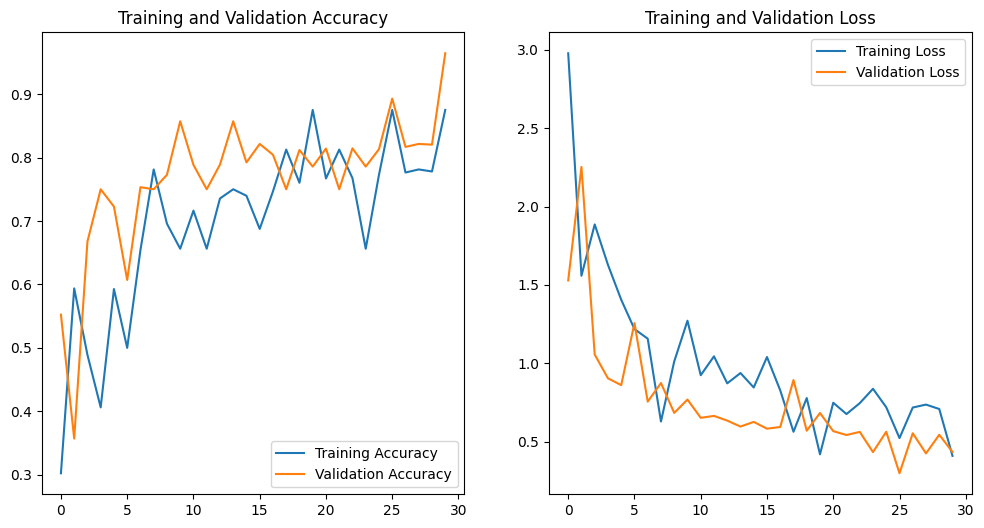

In [16]:
plot_metrics(history)

In [ ]:
# Save the model
model.export('waste_sorting_model')


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('waste_sorting_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('waste_sorting_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the validation split
)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


Found 3100 images belonging to 12 classes.
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8133 - loss: 0.5955
Test Accuracy: 0.82


In [18]:
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Confusion matrix and classification report
print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))

97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step
[[ 10   8   6   9  66   7  11  20  12  26   9   5]
 [  7   8   7   8  81   4  20  11  16  26   1   8]
 [  8   5   3   7  43   2  13   8   9  14   5   4]
 [ 13  11   5   6  74   6  17  10  10  19   6   1]
 [ 60  75  35  42 390  35  66  76  69 146  43  28]
 [  7   4   4   5  45   5  13   3  13  23   1   2]
 [ 11   4   7   7  48   2   7  21  13  18   7   8]
 [ 11  15  11   8  74   8  14  14  11  32   4   8]
 [  6  12   6   4  61   7  10  15  14  24   9   5]
 [ 15  27  10  15 154  10  24  35  24  59  14   8]
 [  7  13   3   9  60   4   3  10   5  16   3   6]
 [  6  11   5   9  52   3  11   9   7  34   5   3]]
              precision    recall  f1-score   support

     battery       0.06      0.05      0.06       189
  biological       0.04      0.04      0.04       197
 brown-glass       0.03      0.02      0.03       121
   cardboard       0.05      0.03      0.04       178
     clothes       0.34      0.37      0.35      1065
 green-glass       0.

In [19]:
def display_predictions(generator, model, num_images=9):
    x_batch, y_batch = next(generator)
    predictions = model.predict(x_batch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_batch, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i])
        plt.axis('off')
        true_label = list(generator.class_indices.keys())[true_classes[i]]
        predicted_label = list(generator.class_indices.keys())[predicted_classes[i]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


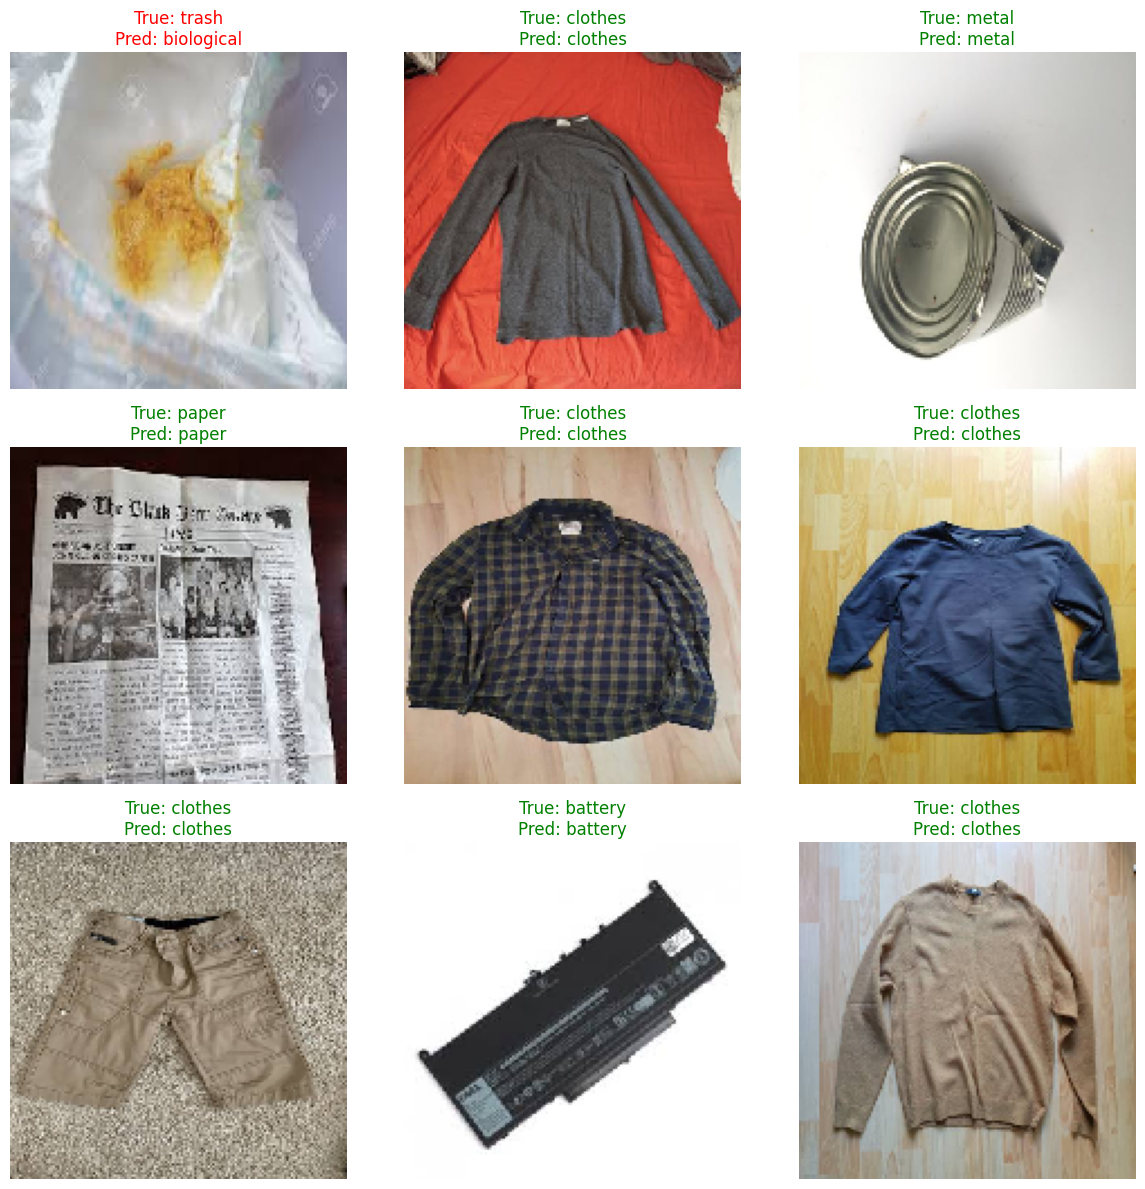

In [20]:
display_predictions(val_generator, model)


In [21]:
def plot_confusion_matrix(y_true, y_pred_classes, class_labels):
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


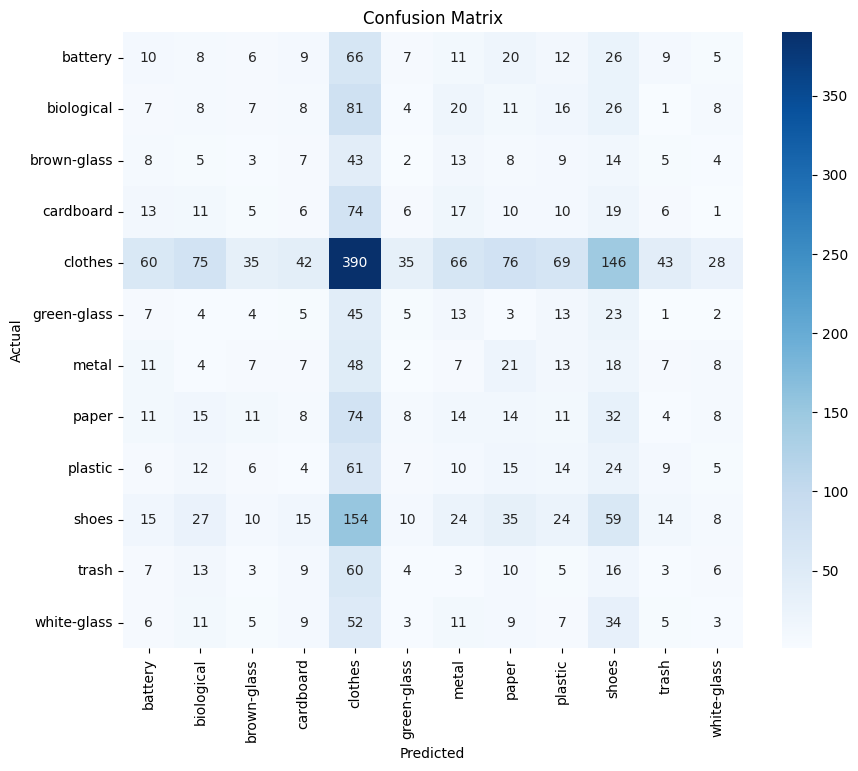

In [22]:
plot_confusion_matrix(y_true, y_pred_classes, list(val_generator.class_indices.keys()))
